<h1>Read in data from database </h1>



In [651]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

In [652]:
connection = sqlite3.connect('database.sqlite') 

In [653]:
#Other tables are not relevant as they are static in time and not reflecting timeseries nature of the data 
countries = pd.read_sql_query("SELECT * from Country", connection)
matches = pd.read_sql_query("SELECT * from Match", connection)
leagues = pd.read_sql_query("SELECT * from League", connection)
teams = pd.read_sql_query("SELECT * from Team", connection)



<H1>Basic Analysis and visualtion</H1>

In [8]:
def get_result(match):
    home = match.home_team_goal
    away = match.away_team_goal
    result = ''
    if home == away:
        result = 'D'
    elif home>away:
        result = 'H'
    else:
        result = 'A'
    return result 
    

In [9]:
matches['result'] =matches.apply(get_result, axis = 1)


In [10]:
def get_best_odds():
    matches['best_home']= matches.apply(lambda x: max(x['B365H'],x['BWH'],x['IWH'],x['LBH'],x['PSH'],x['WHH'],x['SJH'],x['VCH'],x['GBH'],x['BSH']),axis = 1)
    matches['best_draw']= matches.apply(lambda x: max(x['B365D'],x['BWD'],x['IWD'],x['LBD'],x['PSD'],x['WHD'],x['SJD'],x['VCD'],x['GBD'],x['BSD']),axis = 1)
    matches['best_away']= matches.apply(lambda x: max(x['B365A'],x['BWA'],x['IWA'],x['LBA'],x['PSA'],x['WHA'],x['SJA'],x['VCA'],x['GBA'],x['BSA']),axis = 1)

In [11]:
def get_worst_odds():
    matches['worst_home'] = matches.apply(lambda x: min(x['B365H'],x['BWH'],x['IWH'],x['LBH'],x['PSH'],x['WHH'],x['SJH'],x['VCH'],x['GBH'],x['BSH']),axis = 1)
    matches['worst_draw']= matches.apply(lambda x: min(x['B365D'],x['BWD'],x['IWD'],x['LBD'],x['PSD'],x['WHD'],x['SJD'],x['VCD'],x['GBD'],x['BSD']),axis = 1)
    matches['worst_away']= matches.apply(lambda x: min(x['B365A'],x['BWA'],x['IWA'],x['LBA'],x['PSA'],x['WHA'],x['SJA'],x['VCA'],x['GBA'],x['BSA']),axis = 1)

In [12]:
def to_datetime():
    import datetime
    #Switch the date column to datetime object 
    matches['date'] = pd.to_datetime(matches['date'])

In [624]:
get_best_odds()
get_worst_odds()
to_datetime()


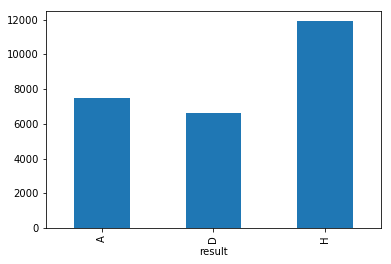

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
result = matches.groupby('result').size()
result.plot(kind = 'bar')

In [15]:
league_results = matches.groupby(['result','league_id'])

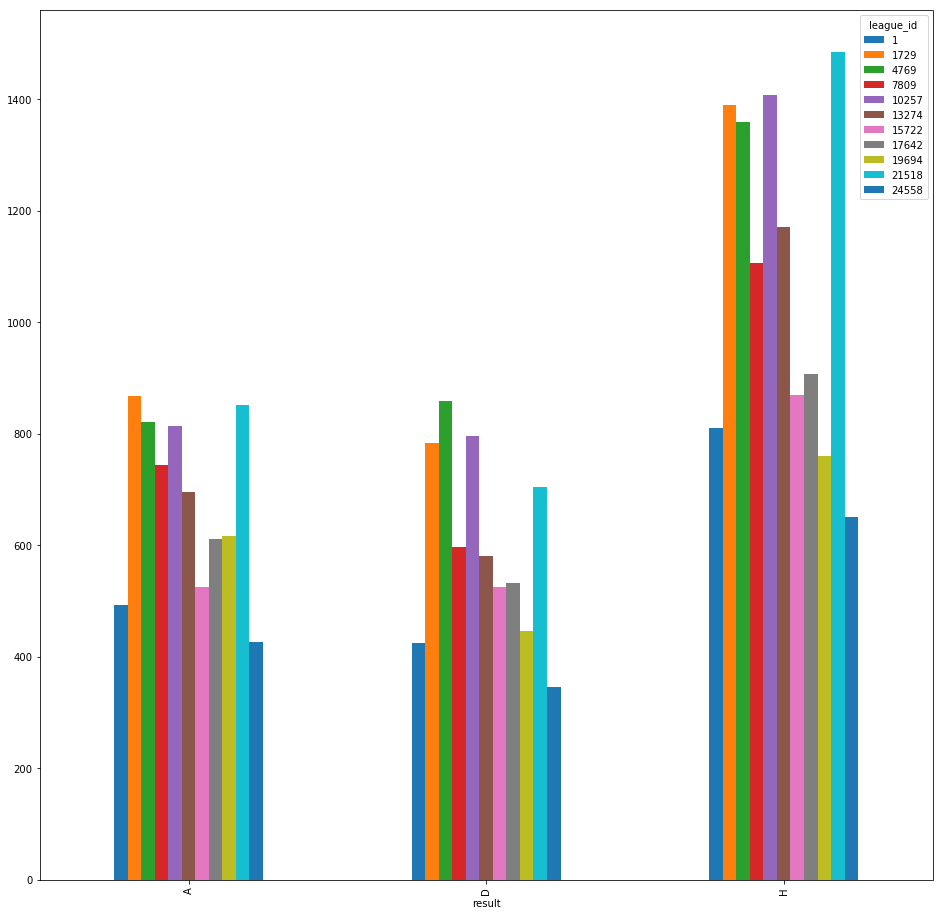

In [16]:
league_results.size().unstack().plot(kind='bar',figsize=(16,16))

In [17]:

#always betting the best odds for the home team 1 dollar per game 
matches['best_home_payout'] = matches['best_home']
matches['best_home_outcome'] = 'H'
matches.loc[~(matches.best_home_outcome==matches.result),'best_home_payout']=0
total_return_home = 100*(matches['best_home_payout'].sum()-matches['best_home_payout'].notnull().count())/matches['best_home_payout'].notnull().count()
total_return_home

-13.840313329997127

In [18]:
#always betting the best odds for the away team 1 dollar per game 
matches['best_away_payout'] = matches['best_away']
matches['best_away_outcome'] = 'A'
matches.loc[~(matches.best_away_outcome==matches.result),'best_away_payout']=0
total_return_away = 100*(matches['best_away_payout'].sum()-matches['best_away_payout'].notnull().count())/matches['best_away_payout'].notnull().count()
total_return_away

-16.870018091535123

In [19]:
#always betting the best odds for the draw 1 dollar per game 
matches['best_draw_payout'] = matches['best_draw']
matches['best_draw_outcome'] = 'D'
matches.loc[~(matches.best_draw_outcome==matches.result),'best_draw_payout']=0
total_return_draw = 100*(matches['best_draw_payout'].sum()-matches['best_draw_payout'].notnull().count())/matches['best_draw_payout'].notnull().count()
total_return_draw

-17.29862581315599

<h1> Data Preprocessing for ML </h1>

<p> -Select only the major leagues</p>

In [773]:

good_leagues = [1729,4769,7809,10257,21518]
good_matches = matches[matches.league_id.isin(good_leagues)]
good_matches.iloc[0].date

'2008-08-17 00:00:00'

In [774]:
def good_matches_to_date ():
    good_matches['date'] = pd.to_datetime(good_matches['date'])
    
good_matches_to_date()

/Users/RyanMiller/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Timestamp('2008-08-17 00:00:00')

In [750]:
def get_good_bookies():
    bookies = get_all_bookies()
    good_bookies = []
    for bookie in bookies:
        name = bookie+'H'
        null = (good_matches[pd.isnull(good_matches[name]) == True])
        num_null = null['id'].count()
        if num_null < 100:
            good_bookies.append(bookie)
    return good_bookies

get_good_bookies()

['B365', 'BW', 'IW', 'LB', 'WH', 'VC']

In [751]:
def get_past_matches(matches,team_id,date,n=10):
    team_matches =  matches[(matches['home_team_api_id'] == team_id) | (matches['away_team_api_id'] == team_id)]
    date = pd.to_datetime(date)
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:n,:]
    return last_matches

In [753]:
def get_past_matches_against_team(matches, date, team1, team2, n=5 ):
    team1_home = matches[(matches['home_team_api_id'] == team1) & (matches['away_team_api_id'] == team2)]    
    team2_home = matches[(matches['home_team_api_id'] == team2) & (matches['away_team_api_id'] == team1)]  
    total_matches = pd.concat([team1_home, team2_home])
    date = pd.to_datetime(date)
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:n,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
    return last_matches
    

In [754]:
def goals(matches, team):
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    #Return total goals
    return total_goals

In [755]:
def goals_against(matches, team):

    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals

In [756]:
def get_wins(matches, team):
    
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    return total_wins      
    

In [757]:
def get_all_bookies():
    all_bookies = ['B365','BW','IW','LB','PS','WH','SJ','VC','GB','BS']
    return all_bookies

In [758]:
def get_odds(match,bookies):
    odds = {}
    for bookie in bookies:
        odds[bookie] = {}
        bookie_h = bookie+'H'
        bookie_a = bookie+'A'
        bookie_d = bookie+'D'        
        odds[bookie]['home'] = match[bookie_h]
        odds[bookie]['away'] = match[bookie_a]
        odds[bookie]['draw'] = match[bookie_d]
    
    return odds



In [759]:
def get_probabilities(odds):
    probs = pd.Series()
    for key in odds:
        home_prob  = 1/odds[key]['home']
        away_prob  = 1/odds[key]['away']
        draw_prob = 1/odds[key]['draw']
        total_prob = home_prob+away_prob+draw_prob
        probs.loc[key+'H'] = home_prob / total_prob
        probs.loc[key+'D'] = draw_prob / total_prob
        probs.loc[key+'A'] = away_prob / total_prob
    return probs


In [760]:
def get_all_probs(match,bookies):
    
    odds = get_odds(match,bookies)
    probs = get_probabilities(odds)
    probs.loc['match_api_id'] = match.match_api_id
    return probs

In [761]:
def get_result_for_merge(match):
    result = pd.Series()
    home = match.home_team_goal
    away = match.away_team_goal
    match_id = match.match_api_id
    result.loc['match_api_id'] = match_id
    if home == away:
        result.loc['result'] = 'D'
    elif home>away:
        result.loc['result'] = 'H'
    else:
        result.loc['result'] = 'A'
    return result 

In [762]:
def get_match_data(match,matches,n =10):
    date = pd.to_datetime(match.date)
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    #Get last x matches of home and away team
    matches_home_team = get_past_matches(matches,home_team,date,n)
    matches_away_team = get_past_matches(matches, away_team,date,n)
    
    
    #Get last x matches of both teams against each other
    last_matches_against = get_past_matches_against_team(matches, date, home_team, away_team)
    
    
    
    
    home_goals = goals(matches_home_team, home_team)
    away_goals = goals(matches_away_team, away_team)
    home_goals_against = goals_against(matches_home_team, home_team)
    away_goals_against = goals_against(matches_away_team, away_team)

    
    data = pd.Series()
    
    
    data.loc[ 'match_api_id'] = match.match_api_id
    data.loc[ 'league_id'] = match.league_id

    data.loc['home_team_goals_difference'] = home_goals - home_goals_against
    data.loc['away_team_goals_difference'] = away_goals - away_goals_against
    data.loc['games_won_home_team'] = get_wins(matches_home_team, home_team) 
    data.loc['games_won_away_team'] = get_wins(matches_away_team, away_team)
    data.loc['games_against_won_home'] = get_wins(last_matches_against, home_team)
    data.loc['games_against_won_away'] = get_wins(last_matches_against, away_team)
    
    return data
    
   
    

In [1094]:
def get_all_matches_data(matches,n =10,players = True ,stats='',bookies = get_good_bookies()):
    match_stats = matches.apply(lambda x: get_match_data(x, matches), axis = 1)
    
   
    bookie_columns = []
    bookies = get_good_bookies()
    for bookie in bookies:
        home = bookie+'H'
        bookie_columns.append(home)
        away = bookie+'A'
        bookie_columns.append(away)
        draw = bookie+'D'
        bookie_columns.append(draw)
     
    
    
    odds = pd.DataFrame()
    for i in bookie_columns:
        odds[i] = matches[i]
    
    
    probs = matches.apply(lambda x: get_all_probs(x,bookies),axis = 1)
    results = matches.apply(get_result_for_merge,axis = 1)
    
    if players == True:
        match_ratings = matches.apply(lambda x: get_match_ratings(x,stats),axis = 1)
        match_stats = pd.merge(match_stats, match_ratings, on = 'match_api_id', how = 'left')


    match_stats = pd.merge(match_stats, probs, on = 'match_api_id', how = 'left')
    match_stats = pd.merge(match_stats,results, on = 'match_api_id',how = 'left')
    
    


    
    
    return odds,match_stats




In [1095]:
odds,simple_match_data =get_all_matches_data(good_matches,players = False) 

In [1097]:
simple_match_data

,match_api_id,league_id,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won_home,games_against_won_away,IWH,IWD,...,LBH,LBD,LBA,B365H,B365D,B365A,WHH,WHD,WHA,result
0,489042,1729,0,0,0,0,0,0,0.690419,0.203987,...,0.712871,0.198020,0.089109,0.739744,0.173504,0.086752,0.712871,0.198020,0.089109,D
1,489043,1729,0,0,0,0,0,0,0.746347,0.172234,...,0.741240,0.177898,0.080863,0.790754,0.145985,0.063260,0.763226,0.162359,0.074415,H
2,489044,1729,0,0,0,0,0,0,0.199482,0.256477,...,0.197697,0.269587,0.532716,0.171786,0.262451,0.565763,0.162078,0.270131,0.567791,A
3,489045,1729,0,0,0,0,0,0,0.495261,0.270142,...,0.496894,0.279503,0.223602,0.495902,0.278580,0.225517,0.485466,0.277626,0.236908,H
4,489046,1729,0,0,0,0,0,0,0.448217,0.280136,...,0.485466,0.277626,0.236908,0.499283,0.280479,0.220238,0.466725,0.278576,0.254699,H
5,489047,1729,0,0,0,0,0,0,0.448217,0.280136,...,0.496894,0.279503,0.223602,0.474820,0.287770,0.237410,0.457420,0.287732,0.254848,A
6,489048,1729,0,0,0,0,0,0,0.310132,0.281057,...,0.317690,0.277978,0.404332,0.297318,0.279829,0.422853,0.307211,0.278410,0.414378,H
7,489049,1729,0,0,0,0,0,0,0.513619,0.272374,...,0.515112,0.262101,0.222786,0.518263,0.270977,0.210760,0.492454,0.285941,0.221604,H
8,489050,1729,0,0,0,0,0,0,0.374101,0.280576,...,0.370582,0.273660,0.355758,0.364821,0.296417,0.338762,0.355080,0.306103,0.338817,H
9,489051,1729,0,0,0,0,0,0,0.690419,0.203987,...,0.693840,0.206710,0.099450,0.714796,0.190136,0.095068,0.683777,0.211645,0.104578,H


<h1>Machine learning using Random Forest classifier </h1>

In [1040]:
def random_forest_classifier(data,gridsearch= True):
    data = data.drop('match_api_id', axis = 1)
    data = data.dropna()
    from sklearn.model_selection import train_test_split
    result = data.loc[:,'result']
    features = data.drop('result', axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(features, result, test_size = 0.2)
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()
    model.fit(x_train,np.ravel(y_train))
    score = model.score(x_test,y_test)
    print("The score of the model is  ",score)


    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(x_test)
    cfm = confusion_matrix(np.ravel(y_test),y_pred)
    from sklearn.metrics import classification_report
    print("classifiation report for model:")
    print(classification_report(y_test,y_pred))



    import matplotlib.pyplot as plt
    %matplotlib inline
    feature_names = [key for key in data]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)),feature_names)
    plt.xlabel('Relative Importance')
    
    
    
    
    if gridsearch == True:
        from sklearn.model_selection import GridSearchCV
        parameters = {
         'n_estimators':(10,15,20,30), 
         'max_depth':(4,5,6,8,10,15),
         'min_samples_split': (2, 4, 8),
         'min_samples_leaf': (4,8,12,16)
    }
        
        model = GridSearchCV(RandomForestClassifier(),parameters)
        model.fit(x_train, np.ravel(y_train))
        best_score = model.best_score_ 
        best_params = model.best_params_
        print("The best score from the GridSearch Randomforest is ",best_score)
        print("the best parameters from the gridsearch are: ",best_params)

        b_model = RandomForestClassifier(max_depth=best_params['max_depth'],min_samples_leaf=best_params['min_samples_leaf'],min_samples_split=best_params['min_samples_split'],n_estimators=best_params['n_estimators'])
        b_model.fit(x_train,np.ravel(y_train))
        
        b_model_score = b_model.score(x_test,y_test)
        print("The gridsearch optimized model score is ", b_model_score)
    
        y_pred_b = b_model.predict(x_test)
        cfm = confusion_matrix(np.ravel(y_test),y_pred_b)
        print(classification_report(y_test,y_pred_b))
        


        

        y_pred_probs = b_model.predict_proba(x_test)
    
    
    else: 
        y_pred_probs =model.predict_proba(x_test)


    
    
    
    probs = pd.DataFrame(y_pred_probs,columns = ["A","D","H"])







    
    bookie_columns = []
    bookies = get_good_bookies()
    for bookie in bookies:
        home = bookie+'H'
        bookie_columns.append(home)
        away = bookie+'A'
        bookie_columns.append(away)
        draw = bookie+'D'
        bookie_columns.append(draw)
    
    bookie_probs = pd.DataFrame()
    for i in bookie_columns:
        bookie_probs[i] = x_test[i]
    bookie_probs.reset_index(inplace = True, drop = True)
    
    result = pd.DataFrame()
    result['result'] = y_test
    result.reset_index(inplace = True, drop = True)
    
    probs = probs.join(bookie_probs)
    probs = probs.join(result)



    return probs
    

The score of the model is   0.475353326439
classifiation report for model:
             precision    recall  f1-score   support

          A       0.44      0.46      0.45       814
          D       0.29      0.23      0.26       720
          H       0.57      0.61      0.59      1367

avg / total       0.46      0.48      0.47      2901

The best score from the GridSearch Randomforest is  0.528270987761
the best parameters from the gridsearch are:  {'min_samples_leaf': 4, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 30}
The gridsearch optimized model score is  0.538779731127
             precision    recall  f1-score   support

          A       0.50      0.47      0.49       814
          D       0.00      0.00      0.00       720
          H       0.55      0.86      0.67      1367

avg / total       0.40      0.54      0.45      2901



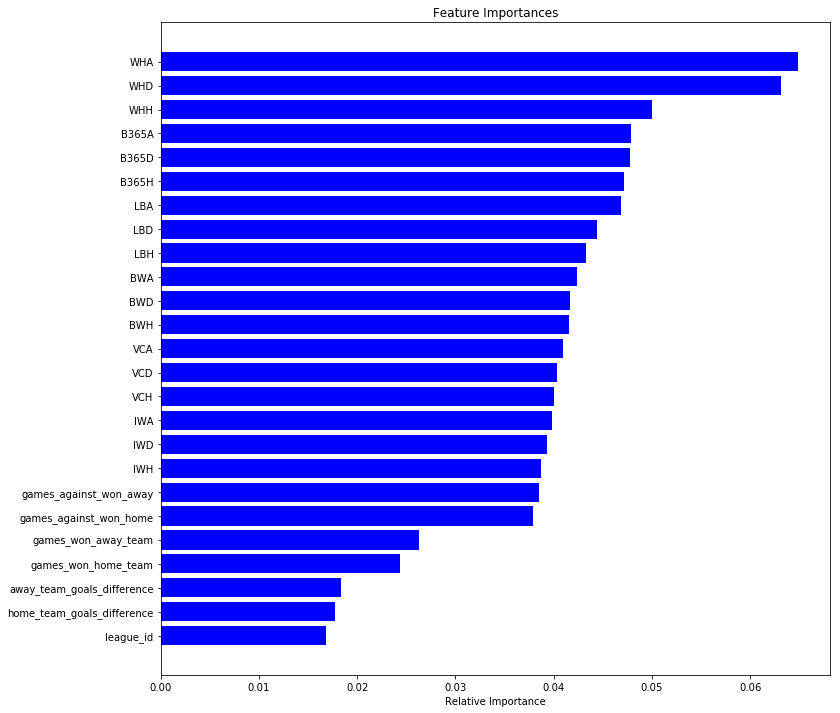

In [1098]:
x = random_forest_classifier(simple_match_data)

<h1>Placing Bets </h1>

In [1133]:
def bet_decider(x):
    bookies = get_good_bookies()
    home_odds = []
    away_odds = []
    draw_odds = []
    for bookie in bookies:
        home = bookie+'H'
        home_odds.append(home)
        away = bookie+'A'
        away_odds.append(away)
        draw = bookie+'D'
        draw_odds.append(draw)

    x['best_home'] = x.apply(lambda x: min(x[i] for i in home_odds),axis = 1)
    x['best_away'] = x.apply(lambda x: min(x[i] for i in away_odds),axis = 1)
    x['best_draw'] = x.apply(lambda x: min(x[i] for i in draw_odds),axis = 1)

    x['home_difference'] = x['H']-x['best_home'] 
    x['away_difference'] = x['A']-x['best_away']
    x['draw_difference'] = x['D']-x['best_draw'] 
    x['max_difference'] = x.apply(lambda x: max(x['home_difference'],x['away_difference'],x['draw_difference']),axis = 1)
    
    
    def get_bet(row):
        
        if row['max_difference']<0:
            return 'no_bet'
    
    
        elif row['max_difference'] == row['home_difference']:
            return 'H'
        elif row['max_difference'] == row['away_difference']:
            return 'A'
        else:
            return 'D'
    

        
    x['bet'] = x.apply(get_bet,axis = 1)
    
    x = x[x['bet']!='no_bet']
    
    def get_odds_from_prob(row):
        bet = row['bet']
        prob = .00001
        if bet == 'A':
            prob = row.best_away
        elif bet == 'H':
            prob = row.best_home
        else: 
            prob= row.best_draw
        odds = 1/prob
        return odds 
    x['bet_odds'] = x.apply(get_odds_from_prob,axis=1)
            
    
    return x 

In [1134]:
rere = bet_decider(x)


,A,D,H,B365H,B365A,B365D,BWH,BWA,BWD,IWH,...,result,best_home,best_away,best_draw,home_difference,away_difference,draw_difference,max_difference,bet,bet_odds
0,0.412643,0.290665,0.296692,0.325444,0.390533,0.284024,0.313450,0.402034,0.284516,0.324873,...,A,0.309845,0.376062,0.279696,-0.013153,0.036581,0.010969,0.036581,A,2.659135
1,0.134438,0.224743,0.640819,0.625430,0.134021,0.240550,0.637088,0.131968,0.230944,0.627010,...,H,0.621495,0.124415,0.227589,0.019324,0.010022,-0.002846,0.019324,H,1.609023
2,0.438898,0.287417,0.273685,0.297530,0.413955,0.288514,0.316561,0.404120,0.279319,0.337909,...,D,0.297530,0.371700,0.279319,-0.023846,0.067198,0.008099,0.067198,A,2.690341
3,0.127299,0.224039,0.648662,0.653846,0.110769,0.235385,0.661688,0.127774,0.210537,0.636557,...,H,0.636557,0.110769,0.209346,0.012106,0.016530,0.014693,0.016530,A,9.027778
4,0.442222,0.260208,0.297569,0.291605,0.421208,0.287187,0.279379,0.432373,0.288248,0.300176,...,H,0.279379,0.409331,0.285061,0.018190,0.032891,-0.024853,0.032891,A,2.443011
5,0.518848,0.262283,0.218870,0.204624,0.525386,0.269990,0.238724,0.487446,0.273830,0.243816,...,D,0.202508,0.487446,0.268551,0.016362,0.031401,-0.006268,0.031401,A,2.051508
6,0.254540,0.302828,0.442632,0.430888,0.263320,0.305792,0.424370,0.276484,0.299146,0.428016,...,D,0.419355,0.258040,0.290323,0.023277,-0.003500,0.012505,0.023277,H,2.384615
7,0.278332,0.302483,0.419185,0.392405,0.303797,0.303797,0.362772,0.329793,0.307434,0.390112,...,H,0.362772,0.289438,0.303797,0.056413,-0.011106,-0.001314,0.056413,H,2.756549
8,0.206966,0.276002,0.517032,0.522388,0.208955,0.268657,0.513342,0.222654,0.264004,0.511951,...,D,0.484759,0.208955,0.262101,0.032273,-0.001989,0.013900,0.032273,H,2.062879
9,0.633015,0.221556,0.145429,0.143701,0.610495,0.245804,0.146659,0.615021,0.238321,0.165547,...,A,0.139222,0.590488,0.232036,0.006207,0.042527,-0.010479,0.042527,A,1.693515


In [1148]:
def get_return_on_one_dollar(bets):
    def bad_bets(row):
        if row.bet !=row.result:
            return 0
        else:
            return row.bet_odds
    bets['bet_odds']= bets.apply(bad_bets,axis=1)
    total_return= 100*(bets['bet_odds'].sum()-bets['bet_odds'].count())/bets['bet_odds'].count()
    return total_return

In [1149]:
get_return_on_one_dollar(rere)

10.822333922559594

<h1>Data Analysis with Player Fifa Ratings </h1>

How are the ratings gotten?

In [791]:
players = pd.read_sql_query("SELECT * from Player", connection)
player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", connection)



In [792]:
def get_match_ratings(match,stats):
    match_id = match['match_api_id']
    date = match.date
    players_stats = pd.Series()
    player_names = []
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    
    
    players_stats.loc['match_api_id']=match_id
    for player in players:
        player_id = match[player]
        new_stats = stats[stats.player_api_id == player_id]
        current_stats  =new_stats[pd.to_datetime(new_stats.date) < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall = 0 
        else:
            current_overall = float(current_stats.overall_rating)
            players_stats.loc[player] = current_overall

    return players_stats
            

In [793]:
match_data_with_players = get_all_matches_data(good_matches,stats = player_attributes)

match_data_with_players


,match_api_id,league_id,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won_home,games_against_won_away,away_player_1,away_player_10,...,LBH,LBD,LBA,B365H,B365D,B365A,WHH,WHD,WHA,result
0,489042,1729,0,0,0,0,0,0,82.0,76.0,...,0.712871,0.198020,0.089109,0.739744,0.173504,0.086752,0.712871,0.198020,0.089109,D
1,489043,1729,0,0,0,0,0,0,77.0,74.0,...,0.741240,0.177898,0.080863,0.790754,0.145985,0.063260,0.763226,0.162359,0.074415,H
2,489044,1729,0,0,0,0,0,0,84.0,84.0,...,0.197697,0.269587,0.532716,0.171786,0.262451,0.565763,0.162078,0.270131,0.567791,A
3,489045,1729,0,0,0,0,0,0,77.0,71.0,...,0.496894,0.279503,0.223602,0.495902,0.278580,0.225517,0.485466,0.277626,0.236908,H
4,489046,1729,0,0,0,0,0,0,65.0,80.0,...,0.485466,0.277626,0.236908,0.499283,0.280479,0.220238,0.466725,0.278576,0.254699,H
5,489047,1729,0,0,0,0,0,0,81.0,76.0,...,0.496894,0.279503,0.223602,0.474820,0.287770,0.237410,0.457420,0.287732,0.254848,A
6,489048,1729,0,0,0,0,0,0,81.0,75.0,...,0.317690,0.277978,0.404332,0.297318,0.279829,0.422853,0.307211,0.278410,0.414378,H
7,489049,1729,0,0,0,0,0,0,74.0,75.0,...,0.515112,0.262101,0.222786,0.518263,0.270977,0.210760,0.492454,0.285941,0.221604,H
8,489050,1729,0,0,0,0,0,0,77.0,75.0,...,0.370582,0.273660,0.355758,0.364821,0.296417,0.338762,0.355080,0.306103,0.338817,H
9,489051,1729,0,0,0,0,0,0,81.0,84.0,...,0.693840,0.206710,0.099450,0.714796,0.190136,0.095068,0.683777,0.211645,0.104578,H


In [ ]:
classified = random_forest_classifier(match_data_with_players)
classified

The score of the model is   0.457489878543
classifiation report for model:
             precision    recall  f1-score   support

          A       0.41      0.43      0.42       745
          D       0.26      0.20      0.23       691
          H       0.56      0.61      0.58      1281

avg / total       0.44      0.46      0.45      2717



In [ ]:
betz = bet_decider(classified)


In [ ]:
get_return_on_one_dollar(betz)


<H2> Current Data  </H2>

<H2> Twitter </H2>

<h3>The data is for the EPL only and one season to limit the computing power needed </h3>

In [655]:
EPL = matches[matches.league_id == 1729]
EPL = EPL[EPL.season == '2015/2016']
EPL

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
4388,4389,1729,1729,2015/2016,1,2015-08-09 00:00:00,1987032,9825,8654,0,...,NaN,1.30,5.75,12.00,NaN,NaN,NaN,NaN,NaN,NaN
4389,4390,1729,1729,2015/2016,1,2015-08-08 00:00:00,1987033,8678,10252,0,...,NaN,2.00,3.50,4.20,NaN,NaN,NaN,NaN,NaN,NaN
4390,4391,1729,1729,2015/2016,1,2015-08-08 00:00:00,1987034,8455,10003,2,...,NaN,1.40,5.00,9.50,NaN,NaN,NaN,NaN,NaN,NaN
4391,4392,1729,1729,2015/2016,1,2015-08-08 00:00:00,1987035,8668,9817,2,...,NaN,1.73,3.90,5.40,NaN,NaN,NaN,NaN,NaN,NaN
4392,4393,1729,1729,2015/2016,1,2015-08-08 00:00:00,1987036,8197,8472,4,...,NaN,2.00,3.40,4.33,NaN,NaN,NaN,NaN,NaN,NaN
4393,4394,1729,1729,2015/2016,1,2015-08-08 00:00:00,1987037,10260,8586,1,...,NaN,1.67,4.00,5.75,NaN,NaN,NaN,NaN,NaN,NaN
4394,4395,1729,1729,2015/2016,1,2015-08-09 00:00:00,1987038,10261,8466,2,...,NaN,2.88,3.25,2.70,NaN,NaN,NaN,NaN,NaN,NaN
4395,4396,1729,1729,2015/2016,1,2015-08-08 00:00:00,1987039,9850,9826,1,...,NaN,2.60,3.25,3.00,NaN,NaN,NaN,NaN,NaN,NaN
4396,4397,1729,1729,2015/2016,1,2015-08-09 00:00:00,1987040,10194,8650,0,...,NaN,3.40,3.40,2.30,NaN,NaN,NaN,NaN,NaN,NaN
4397,4398,1729,1729,2015/2016,1,2015-08-10 00:00:00,1987041,8659,8456,0,...,NaN,5.50,4.00,1.70,NaN,NaN,NaN,NaN,NaN,NaN


In [663]:
def get_teams_date(match,team_list):
    match_info = pd.Series()
    date = match.date
    home_team_id = match.home_team_api_id
    away_team_id = match.away_team_api_id
    match_id = match.match_api_id
    home_team = teams[teams.team_api_id == home_team_id]
    home_team_name = home_team.team_long_name.iloc[0]
    away_team = teams[teams.team_api_id == away_team_id].iloc[0]
    away_team_name = away_team.team_long_name
    match_info.loc['match_api_id'] = match_id
    match_info.loc['home_team'] = home_team_name
    match_info.loc['away_team'] = away_team_name
    match_info.loc['date'] = date 
    return match_info

In [664]:
all_teams_and_date = EPL.apply(lambda x: get_teams_date(x,teams),axis = 1)



In [665]:
all_teams_and_date.iloc[0]['date']

'2015-08-09 00:00:00'

In [666]:
all_teams_and_date['date'] = pd.to_datetime(all_teams_and_date['date'])

In [667]:
all_teams_and_date

,match_api_id,home_team,away_team,date
4388,1987032,Arsenal,West Ham United,2015-08-09
4389,1987033,Bournemouth,Aston Villa,2015-08-08
4390,1987034,Chelsea,Swansea City,2015-08-08
4391,1987035,Everton,Watford,2015-08-08
4392,1987036,Leicester City,Sunderland,2015-08-08
4393,1987037,Manchester United,Tottenham Hotspur,2015-08-08
4394,1987038,Newcastle United,Southampton,2015-08-09
4395,1987039,Norwich City,Crystal Palace,2015-08-08
4396,1987040,Stoke City,Liverpool,2015-08-09
4397,1987041,West Bromwich Albion,Manchester City,2015-08-10


In [668]:
consumer_key= '6lqVdjCQMK02VD794gFYhCW6R'
consumer_secret = 'df1fPApSuTxiKbhmuPHrv676nf3HARUMeH6qIeREYnB5Yx2RVo'
access_token = '1458429896-NcLdTaRNd3qB6OcWiSfpJnwMyX5i2wbWrlQgxju'
access_token_secret = 'i1DD5moVCrJLU0DgJOiTlZsip8OkqiSynWNSchBppBPpB'

In [686]:
import tweepy

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
search_term = 'West Ham United'
## fill in your search query and store your results in a variable
results = api.search(q = search_term, lang = "en", result_type = "recent", count = 10)



In [687]:
print(type(results))
print(len(results))
print(type(results[0]))

<class 'tweepy.models.SearchResults'>
9
<class 'tweepy.models.Status'>


In [688]:
print(results[0]._json.keys())

dict_keys(['in_reply_to_status_id', 'truncated', 'favorite_count', 'in_reply_to_screen_name', 'in_reply_to_user_id_str', 'metadata', 'in_reply_to_user_id', 'text', 'favorited', 'geo', 'lang', 'entities', 'possibly_sensitive', 'in_reply_to_status_id_str', 'user', 'coordinates', 'is_quote_status', 'place', 'id', 'id_str', 'retweeted', 'source', 'contributors', 'created_at', 'retweet_count'])


In [690]:
print(results[0]._json['text'])

West Ham United 'will not rush Javier Hernandez back into action' https://t.co/y0AX6hFCZ6 (Source: Sports Mole)


In [691]:
for i in range(len(results)):
    print(results[i]._json['text'])

West Ham United 'will not rush Javier Hernandez back into action' https://t.co/y0AX6hFCZ6 (Source: Sports Mole)
RT @boleynbadges: Bryan Pop Robson West Ham United 1976 https://t.co/gVU4b3RMwa
David Moyes looks set to be given a big boost ahead of Saturday's game against Chelsea.
https://t.co/E9bumWA5df
In the minouette shop: West Ham United Football Club - Hand Engraved Pint Glass by EventCapture at… https://t.co/EGtjNC2Blu
West Ham United 'will not rush Javier Hernandez back into action' https://t.co/HNoW4UVjTJ #whufc #coyi
West Ham United 'will not rush Javier Hernandez back into action' https://t.co/UVOmA3QVH3 #whufc #coyi
RT @realwesthamfans: Let's get our West Ham United back!! https://t.co/qrPImEEcBA
Official WEST HAM UNITED FC Stationery

https://t.co/R5cvSLGJLX

RT's Appreciated and Welcomed https://t.co/iS2dPkZcCQ
RT @boleynbadges: Bryan Pop Robson West Ham United 1976 https://t.co/gVU4b3RMwa
